# Building a Multilevel Model in BRMS Tutorial: Popularity Data

**Authors**: original R Tutorial created by Laurent Smeets and Rens van de Schoot, with updates by Duco Veen; Python translation by Florian Metwaly.

## Introduction

This document shows how you can replicate the popularity data multilevel models from the book [Multilevel analysis: Techniques and applications](https://www.rensvandeschoot.com/multilevel-book/), Chapter 2. In this manual the software package [bambi, version 0.15.0 ](https://bambinos.github.io/bambi/) for Python was used. Results should be very similar to results obtained with other software packages. However, due to convergence and rounding issues, you might notice minor differences.

## Bayesian Method

This tutorial will first build towards a full multilevel model with random slopes and cross level interaction using uninformative priors and then will show the influence of using different (informative) priors on the final model. Of course, it is always possible to already specify the informative priors for the earlier models. We make use of the bambi library, because this library gives us the actual posterior samples, lets us specify a wide range of priors, and using the similar input structure to that of the `lme4` R package. See [here](https://www.rensvandeschoot.com/tutorials/lme4/) for a tutorial on how to use that package.

The key difference between Bayesian statistical inference and frequentist statistical methods concerns the nature of the unknown parameters that you are trying to estimate. In the frequentist framework, a parameter of interest is assumed to be unknown, but fixed. That is, it is assumed that in the population there is only one true population parameter, for example, one true mean or one true regression coefficient. In the Bayesian view of subjective probability, all unknown parameters are treated as uncertain and therefore are be described by a probability distribution. Every parameter is unknown, and everything unknown receives a distribution.


Consequently, in frequentist inference, you are primarily provided with a point estimate of the unknown but fixed population parameter. This is the parameter value that, given the data, is most likely in the population. An accompanying confidence interval tries to give you further insight into the uncertainty that is attached to this estimate. It is important to realize that a confidence interval simply constitutes a simulation quantity. Over an infinite number of samples taken from the population, the procedure to construct a (95%) confidence interval will let it contain the true population value 95% of the time. This does not provide you with any information on how probable it is that the population parameter lies within the confidence interval boundaries that you observe in your very specific and sole sample that you are analyzing.

In Bayesian analyses, the key to your inference is the parameter of interest's posterior distribution. It fulfils every property of a probability distribution and quantifies how probable it is for the population parameter to lie in certain regions. On the one hand, you can characterize the posterior by its mode. This is the parameter value that, given the data and its prior probability, is most probable in the population. Alternatively, you can use the posterior's mean or median. Using the same distribution, you can construct a 95% credibility interval, the counterpart to the confidence interval in frequentist statistics. Other than the confidence interval, the Bayesian counterpart directly quantifies the probability that the population value lies within certain limits. There is a 95% probability that the parameter value of interest lies within the boundaries of the 95% credibility interval. Unlike the confidence interval, this is not merely a simulation quantity, but a concise and intuitive probability statement. For more on how to interpret Bayesian analysis, check [Van de Schoot et al. 2014.](https://onlinelibrary.wiley.com/doi/abs/10.1111/cdev.12169)

## Step 1: setting up packages

The main package that is used for this analysis is [bambi](https://bambinos.github.io/bambi/). For more information and a tutorial on how to install these please have a look at: https://bambinos.github.io/bambi/. The bambi library is build on [PyMC](https://www.pymc.io/welcome.html). PyMC is a probabilistic programming library for Python, which implements many of the features of STAN. If you encounter performance issues, before installing bambi, install PyMC following their guide: https://www.pymc.io/projects/docs/en/stable/installation.html.

If you are using Google Colab, remove the `#` and run the following lines to install the needed libraries

In [21]:
#!pip install bambi
#!pip install pyreadstat

After you have installed `bambi`, you need to load some more libraries that we need for this tutorial.

In [22]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import statsmodels.api as sm
import matplotlib.cm as cm

SEED = 1337

## Step 2: Downloading the data

The popularity dataset contains characteristics of pupils in different classes. The main goal of this tutorial is to find models and test hypotheses about the relation between these characteristics and the popularity of pupils (according to their classmates). To download the popularity data go to https://github.com/MirjamMoerbeek/Data_Sets_ML_book/blob/main/popular2.sav. We will use the .sav file which can be found in the SPSS folder. After downloading the data to your working directory you can open it with the `pandas` library using the `pd.read_spss()` command.

Alternatively, you can directly download them from GitHub into your working directory using the following command (this also works well if you are on Google Colab!):

In [23]:
url = "https://github.com/MirjamMoerbeek/Data_Sets_ML_book/raw/main/popular2.sav"

# Download the file
with open("popular2.sav", "wb") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.content)

In [24]:
popular2data = pd.read_spss("popular2.sav")

There are some variables in the dataset that we do not use, so we can select the variables we will use and have a look at the first few observations:

In [25]:
# We select just the variables we will use
popular2data = popular2data[["pupil", "class", "extrav", "sex", "texp", "popular"]]

# Display the first 6 observations
popular2data.head(6)

pupil  class  extrav   sex  texp  popular
0    1.0    1.0     5.0  girl  24.0      6.3
1    2.0    1.0     7.0   boy  24.0      4.9
2    3.0    1.0     4.0  girl  24.0      5.3
3    4.0    1.0     3.0  girl  24.0      4.7
4    5.0    1.0     5.0  girl  24.0      6.0
5    6.0    1.0     4.0   boy  24.0      4.7

## Step 3: Plotting the Data

Before we start the analysis, we can plot the relationship between extraversion and popularity, without taking into consideration the multilevel structure of the data.

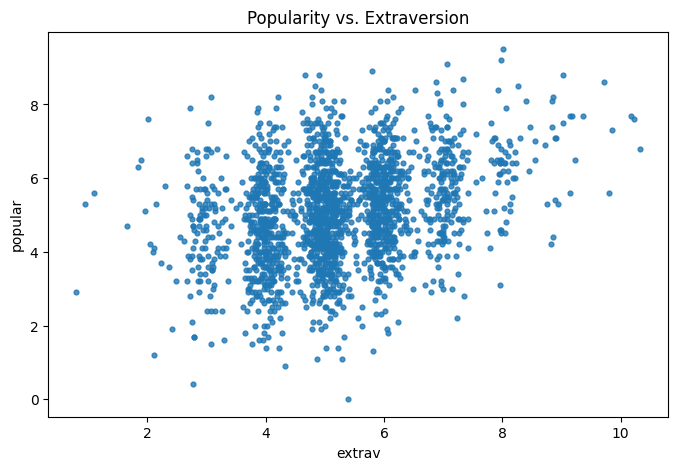

In [26]:
# Add some random noise for better plotting
jitter_strength = 0.2
extrav_jittered = popular2data['extrav'] + np.random.normal(0, jitter_strength, size=len(popular2data))

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(extrav_jittered, popular2data['popular'], alpha=0.8, s=12)
plt.title("Popularity vs. Extraversion")
plt.xlabel("extrav")
plt.ylabel("popular")
plt.show()

Now we can add a regression line to this plot.

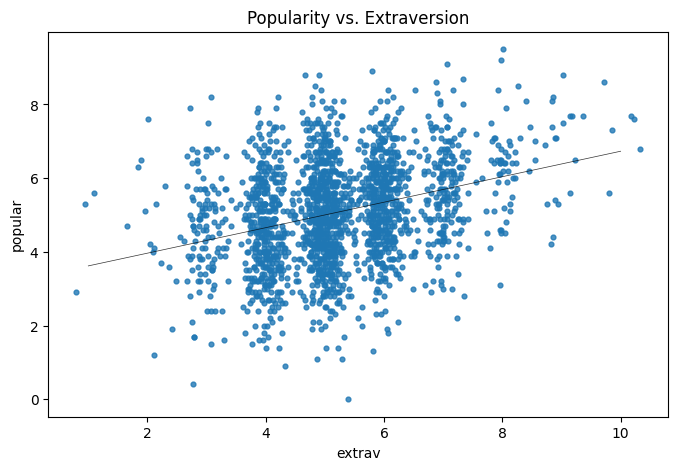

In [27]:
plt.figure(figsize=(8, 5))
plt.scatter(extrav_jittered, popular2data['popular'], alpha=0.8, s=12)
# Regression line (on original, non-jittered data)
sns.regplot(x='extrav', y='popular', data=popular2data,
            ci=None,
            scatter=False,
            color='black',
            line_kws={'linewidth': 0.5, 'alpha': 0.8})
plt.title("Popularity vs. Extraversion")
plt.xlabel("extrav")
plt.ylabel("popular")
plt.show()

So far we have ignored the nested multilevel structure of the data. We can show this multilevel structure by colour coding the different classes.

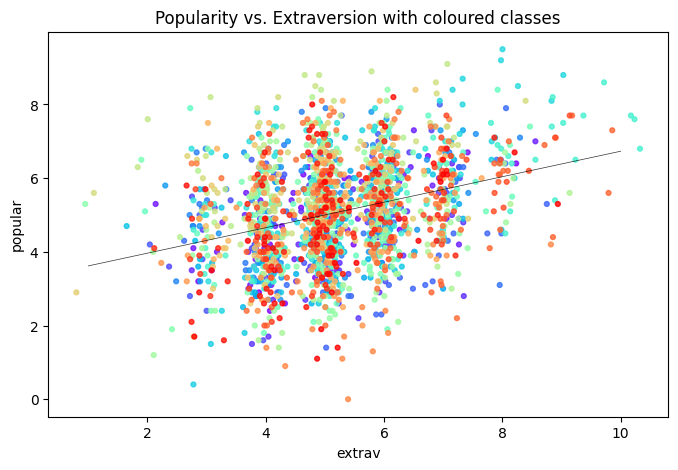

In [28]:
# Create a colormap using rainbow with 100 levels
cmap = plt.get_cmap('rainbow')

# Normalize class to 0-1 for colormap
norm = plt.Normalize(popular2data['class'].min(), popular2data['class'].max())
colors = cmap(norm(popular2data['class']))

plt.figure(figsize=(8, 5))
plt.scatter(extrav_jittered, popular2data['popular'], c=colors, alpha=0.8, s=12)
# Regression line (on original, non-jittered data)
sns.regplot(x='extrav', y='popular', data=popular2data,
            ci=None,
            scatter=False,
            color='black',
            line_kws={'linewidth': 0.5, 'alpha': 0.8})
plt.title("Popularity vs. Extraversion with coloured classes")
plt.xlabel("extrav")
plt.ylabel("popular")
plt.show()

Now we can draw different regression lines for the 100 different classes in the data

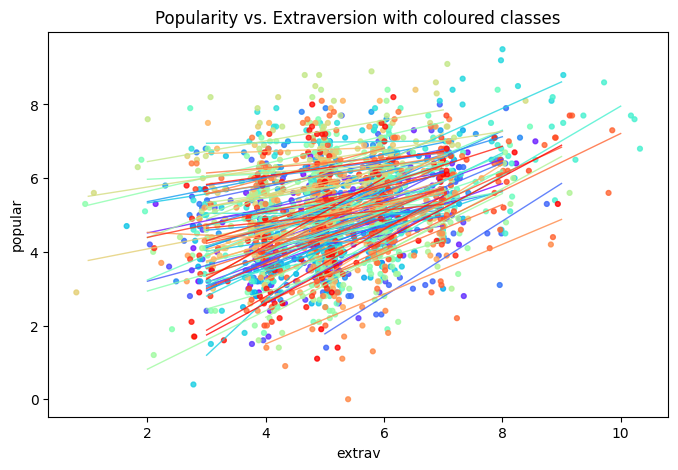

In [29]:
# Create colormap and normalize class values
cmap = plt.get_cmap('rainbow')
classes = popular2data['class'].unique()
norm = plt.Normalize(popular2data['class'].min(), popular2data['class'].max())
colors = cmap(norm(popular2data['class']))

# Create figure
plt.figure(figsize=(8, 5))

# Scatter jittered points
plt.scatter(extrav_jittered, popular2data['popular'], c=colors, alpha=0.8, s=12)

# Add class-specific regression lines (using non-jittered data)
for cls in classes:
    subset = popular2data[popular2data['class'] == cls]
    color = cmap(norm(cls))
    sns.regplot(
        data=subset,
        x='extrav', y='popular',
        scatter=False,
        ci=None,
        color=color,
        line_kws={'linewidth': 1, 'alpha': 0.8}
    )

# Labels and title
plt.title("Popularity vs. Extraversion with coloured classes")
plt.xlabel("extrav")
plt.ylabel("popular")
plt.show()

We clearly see that the relationship between extraversion and popularity is not the same in all classes, but on average there is a clear positive relationship. In this tutorial, we will show the estimation of these different slopes (and how the explain these differences). Again, for more information please refer to the book [Multilevel analysis: Techniques and applications](https://www.rensvandeschoot.com/multilevel-book/).

We can also colour code the most extreme regression lines.

In [30]:
# To colour code the extremes, we need to write a small function that calculates the regression lines and adds a column indicating which clusters have the most extreme.

def tag_extreme_slopes(data, x, y, grouping, n_highest=3, n_lowest=3):
    # Store group-level slopes
    coefs = []
    for group, group_df in data.groupby(grouping):
        if len(group_df) >= 2:  # need at least 2 points to fit a line
            X = sm.add_constant(group_df[x])
            model = sm.OLS(group_df[y], X).fit()
            slope = model.params[x]
            coefs.append((group, slope))

    coef_df = pd.DataFrame(coefs, columns=[grouping, 'coef'])

    # Tag top and bottom slopes
    top = coef_df.nlargest(n_highest, 'coef')
    bottom = coef_df.nsmallest(n_lowest, 'coef')

    coef_df['high_and_low'] = 'none'
    coef_df.loc[coef_df[grouping].isin(top[grouping]), 'high_and_low'] = 'top'
    coef_df.loc[coef_df[grouping].isin(bottom[grouping]), 'high_and_low'] = 'bottom'

    # Merge tag back into original data
    return pd.merge(data, coef_df, on=grouping, how='left')


In [31]:
popular2tagged = tag_extreme_slopes(
    data=popular2data,
    x='extrav',
    y='popular',
    grouping='class',
    n_highest=3,
    n_lowest=3
)


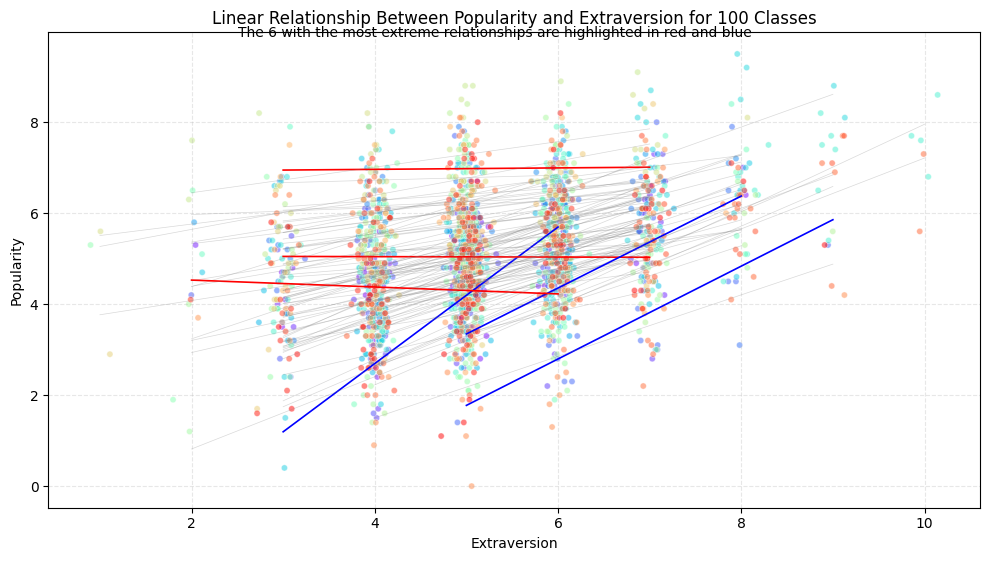

In [32]:
plt.figure(figsize=(10, 6))

# Create colormap
cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(popular2tagged['class'].min(), popular2tagged['class'].max())
colors = cmap(norm(popular2tagged['class']))

# Scatterplot with jitter (x-axis only)
jitter = np.random.normal(0, 0.1, size=len(popular2tagged))
plt.scatter(popular2tagged['extrav'] + jitter,
            popular2tagged['popular'],
            c=colors,
            alpha=0.5,
            s=20,
            edgecolors='white',
            linewidths=0.5)

# Draw regression lines by class
for cls, group_df in popular2tagged.groupby('class'):
    color = 'grey'
    lw = 0.5
    alpha = 0.3

    tag = group_df['high_and_low'].iloc[0]
    if tag == 'top':
        color = 'blue'
        lw = 1.2
        alpha = 1.0
    elif tag == 'bottom':
        color = 'red'
        lw = 1.2
        alpha = 1.0

    sns.regplot(data=group_df,
                x='extrav',
                y='popular',
                scatter=False,
                ci=None,
                color=color,
                line_kws={'linewidth': lw, 'alpha': alpha})

# Final touches
plt.title("Linear Relationship Between Popularity and Extraversion for 100 Classes")
plt.suptitle("The 6 with the most extreme relationships are highlighted in red and blue", fontsize=10, y=0.9)
plt.xlabel("Extraversion")
plt.ylabel("Popularity")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Step 4: Analysing the Data

### Intercept only model

Since the bambi package (via PyMC) makes use of a Hamiltonian Monte Carlo sampler algorithm (MCMC) to approximate the posterior (distribution), we need to specify a few more parameters than in a frequentist analysis.


1.  First we need the specify how many iteration we want the MCMC to run.
2.  We need to specify how many chains we want to run.
3.  We need to specify how many iterations we want to discard per chain (warmup or burnin phase).
4.  We need to specify what our initial values are for the different chains for the parameters of interest. or we can just tell bambi that we want random values as initial values.

We need to specify all these values for replicability purposes. In addition, if the two chains would not converge we can specify more iterations, different starting values and a longer warmup period. Thankfully bambi will tell us if the sampler is likely to be non-converged.

The first model that we replicate is the intercept only model.
If we look at the different inputs for the `bmb.Model()` function we:

1.  have "popular", which indicates the dependent variable we want to predict.
2.  a "~", that we use to indicate that we now give the other variables of interest.
3.  a "1" in the formula the function indicates the intercept.
4.  since this is an intercept only model, we do not have any other independent variables here.
5.  between brackets we have the random effects/slopes. Again the value 1 is to indicate the intercept and the variables right of the vertical "|" bar is used to indicate grouping variables. In this case the class ID. So the dependent variable 'popular' is predicted by an intercept and a random error term for the intercept.
6.  Finally, we specify which dataset we want to use after the `data=` command.

In [33]:
interceptonlymodeltest = bmb.Model("popular ~ 1 + (1|class)",
                                   data=popular2data,
                                   center_predictors=False # bambi will automatically center the predictors, here you turn it off
                                    )
fit_interceptonlymodeltest = interceptonlymodeltest.fit(random_seed=SEED, # set seed for replicability
                                                        tune=100,
                                                        draws=200,
                                                        chains = 2,
                                                        initvals=None, # here we tell bambi to use random initial values
                                                        cores=None) # with the cores argument you can specify how many cores you want to use to run the chains. With the standart value ("None"), bambi by default will try to run all chains in parallel

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
az.summary(fit_interceptonlymodeltest)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
1|class[1.0]    0.005  0.249  -0.452    0.465      0.009    0.012     840.0   
1|class[2.0]   -0.887  0.263  -1.363   -0.380      0.011    0.018     560.0   
1|class[3.0]   -0.347  0.249  -0.801    0.076      0.012    0.017     450.0   
1|class[4.0]    0.334  0.227  -0.091    0.709      0.010    0.012     472.0   
1|class[5.0]    0.195  0.228  -0.186    0.608      0.011    0.014     395.0   
...               ...    ...     ...      ...        ...      ...       ...   
1|class[99.0]  -0.214  0.224  -0.629    0.192      0.011    0.009     438.0   
1|class[100.0] -0.874  0.253  -1.320   -0.398      0.011    0.014     517.0   
1|class_sigma   0.851  0.069   0.732    0.995      0.007    0.004     106.0   
Intercept       5.077  0.079   4.936    5.228      0.009    0.005      77.0   
sigma           1.105  0.019   1.070    1.138      0.001    0.001     327.0   

                ess_tail  r_hat  
1|class[1.0]       373.0   1.00  
1|class[2.0]       191.0   1.00  
1|class[3.0]       211.0   1.01  
1|class[4.0]       217.0   1.00  
1|class[5.0]       365.0   1.01  
...                  ...    ...  
1|class[99.0]      326.0   1.01  
1|class[100.0]     218.0   1.01  
1|class_sigma      189.0   1.02  
Intercept          128.0   1.01  
sigma              250.0   1.00  

[103 rows x 9 columns]

For this model we have specified very few iterations and a short burn-in period, which yields the warning *"The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details"* So we do so. From now on, to keep this tutorial of a reasonable length, the process of the bambi MCMC sampler is no longer shown.

In [35]:
interceptonlymodel = bmb.Model("popular ~ 1 + (1|class)",
                                   data=popular2data,
                                   center_predictors=False # bambi will automatically center the predictors, here you turn it off
                                    )
fit_interceptonlymodel = interceptonlymodel.fit(random_seed=SEED, # set seed for replicability
                                                        tune=1000,
                                                        draws=2000,
                                                        chains = 2)

Output()

In [36]:
az.summary(fit_interceptonlymodel, var_names=["sigma", "Intercept", "1|class_sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma          1.106  0.018   1.073    1.140      0.000    0.000    6081.0   
Intercept      5.079  0.088   4.924    5.261      0.003    0.002     721.0   
1|class_sigma  0.848  0.069   0.723    0.976      0.002    0.001    1056.0   

               ess_tail  r_hat  
sigma            2536.0    1.0  
Intercept        1064.0    1.0  
1|class_sigma    1865.0    1.0

Now we do not get any warnings and can check the results. We see that the intercept (mean) is 5.08 and that the credible interval ranges from 4.91 to 5.25. In the brms output, not the variance of the first and second level is given, but instead the standard deviation. So, if we want to calculate the Intraclass correlation (ICC) we need to do this ourselves. The posterior mean of the residual variance (our best guess for now) on the class level is  $0.85^2= .72$ and the residual variance on the first level (pupil level) is $1.11^2= 1.23$, which means that the ICC= $\frac{0.85^2}{(0.85^2+1.11^2)}=.37$

Alternatively, we can also use of the following code to calculate the ICC and the 95% CCI of the ICC. From this we can see if 0 is included in the 95% ICC. In our example that is not the case which means a multilevel model is warranted.

In [37]:
# Extract posterior samples
posterior = fit_interceptonlymodel.posterior

sd_class = posterior["1|class_sigma"]
sigma = posterior["sigma"]

# Compute ICC for each posterior draw
icc = (sd_class ** 2) / (sd_class ** 2 + sigma ** 2)

az.summary(icc, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  0.37  0.038     0.293      0.443      0.001    0.001    1070.0    1856.0   

   r_hat  
x    1.0

### First Level Predictors

Now we can add first (student) level predictors. The first level predictors are sex and extraversion. For now, we just add them as fixed effects and not yet as random slopes. Furthermore, we do not yet specify any priors for the regression coefficients, which means that bambi will pick priors that are non or very weakly informative, so that their influence on the results will be negligible.

In [38]:
model1 = bmb.Model("popular ~ 1 + sex + extrav + (1|class)",
                                   data=popular2data,
                                   center_predictors=False # bambi will automatically center the predictors, here you turn it off
                                    )
fit_model1 = model1.fit(random_seed=SEED, # set seed for replicability
                                                        tune=1000,
                                                        draws=2000,
                                                        chains = 2)

Output()

In [39]:
az.summary(fit_model1, var_names=["sigma", "Intercept", "sex", "extrav"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma      0.770  0.013   0.746    0.794      0.000    0.000    7722.0   
Intercept  2.142  0.121   1.921    2.366      0.004    0.002     775.0   
sex[girl]  1.253  0.036   1.186    1.320      0.000    0.001    7512.0   
extrav     0.441  0.016   0.410    0.470      0.000    0.000    5659.0   

           ess_tail  r_hat  
sigma        2481.0    1.0  
Intercept    1586.0    1.0  
sex[girl]    3014.0    1.0  
extrav       3324.0    1.0

Again, we get no warnings and we can interpret the results. However, because we now have multiple parameters of interest we can visualize the convergence in so-called caterpillar plots. We see that after a few iterations, the 2 chains converge into a nice fat caterpillar.

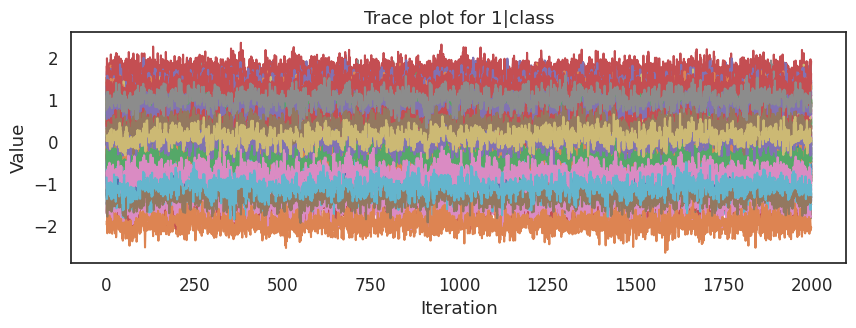

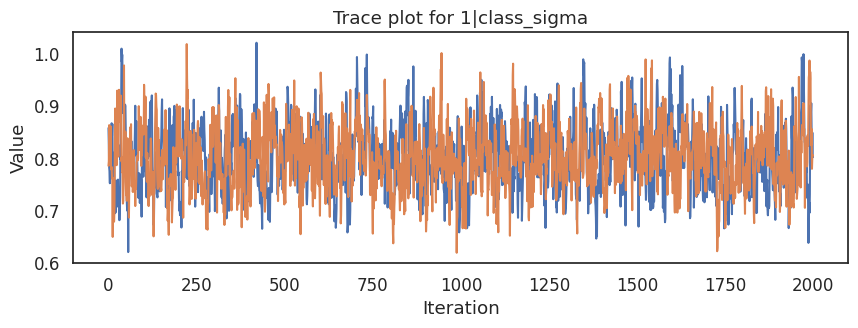

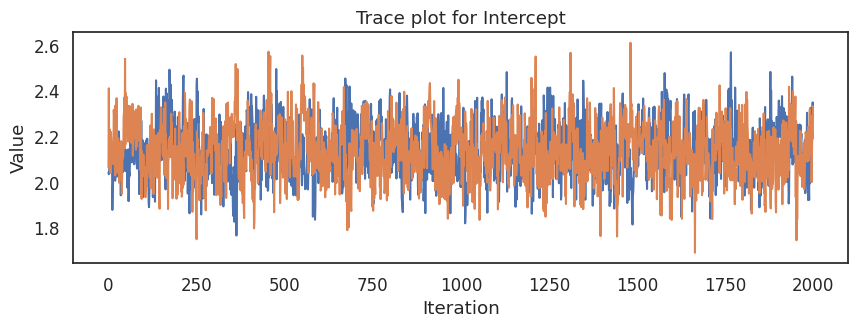

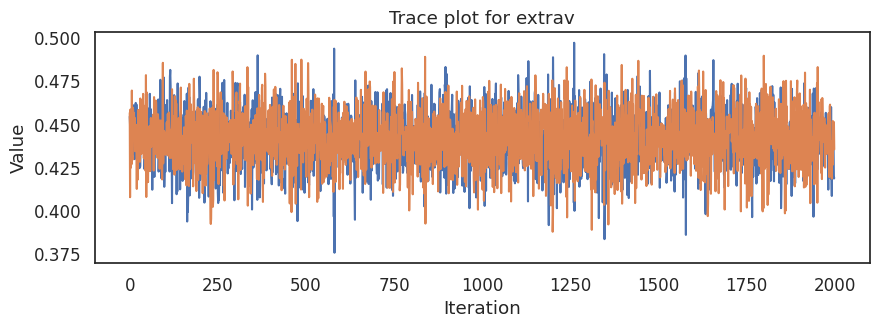

In [92]:
# Extract the posterior samples
## NOTE: The burn in phase is automatically discarded by bambi, so those draws are not shown in the plots
samples = fit_model1.posterior

# Extract variable names
parameters = list(samples.keys())

parameters = parameters[:-2] # dont include the multilevel structure in the trace plots

# Plot each parameters trace plot
for param in parameters:
    values = samples[param]
    plt.figure(figsize=(10, 3))
    for chain in range(values.shape[0]):
        plt.plot(values[chain].values, label=f"Chain {chain}")
    plt.title(f"Trace plot for {param}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

The intercept is now 2.14 (which represent the mean of the posterior distribution), the mean of the posterior for the regression coefficient for sex is 1.25, and the regression coefficient for extraversion 0.44. In a Bayesian analysis we do not have p-values as we do have in a frequentist analysis and corresponding hypothesis tests. To test whether all regression coefficients are different from zero, we can look at the Credible Intervals that are listed in the summary output or we can visually represent them in density plots. If we do so, we clearly see that zero is not included in any of the density plots, meaning that we can be reasonably certain the regression coefficients are different from zero.

In [41]:
# Convert posterior samples to long DataFrame
df = samples.stack().to_dataframe()

In [42]:
# Get HDI values
summary = az.summary(samples, hdi_prob=0.95)
intercept_hdi = summary.loc["Intercept", ["hdi_2.5%", "hdi_97.5%"]]

plt.figure(figsize=(6, 4))
sns.kdeplot(df["Intercept"], fill=True, color="yellow", alpha=0.5)
plt.axvline(0, color="red", linewidth=1)
plt.axvline(intercept_hdi.iloc[0], color="blue", linestyle="--")
plt.axvline(intercept_hdi.iloc[1], color="blue", linestyle="--")
plt.xlim(-1, 3)
plt.title("Posterior Density of Intercept")
plt.xlabel("Value")
plt.grid(True)
plt.show()

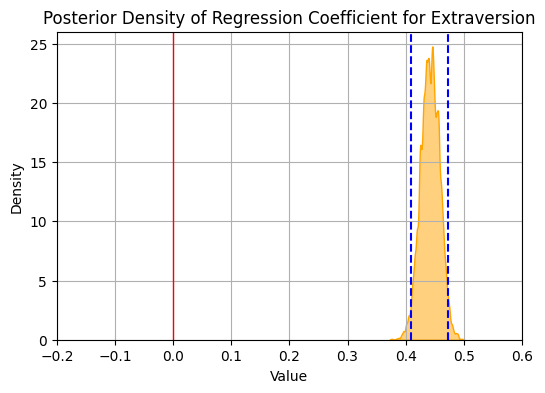

In [43]:
extrav_hdi = summary.loc["extrav", ["hdi_2.5%", "hdi_97.5%"]]

plt.figure(figsize=(6, 4))
sns.kdeplot(df["extrav"], fill=True, color="orange", alpha=0.5)
plt.axvline(0, color="red", linewidth=1)
plt.axvline(extrav_hdi.iloc[0], color="blue", linestyle="--")
plt.axvline(extrav_hdi.iloc[1], color="blue", linestyle="--")
plt.xlim(-0.2, 0.6)
plt.title("Posterior Density of Regression Coefficient for Extraversion")
plt.xlabel("Value")
plt.grid(True)
plt.show()

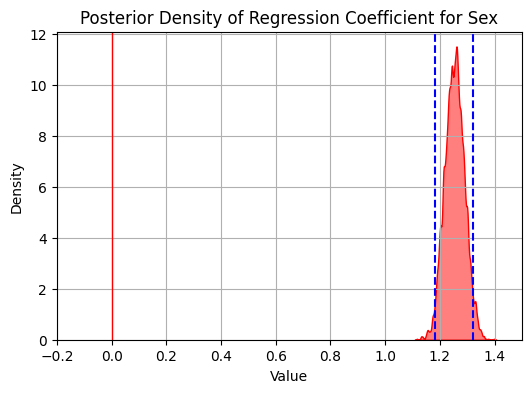

In [44]:
sex_hdi = summary.loc["sex[girl]", ["hdi_2.5%", "hdi_97.5%"]]

plt.figure(figsize=(6, 4))
sns.kdeplot(df["sex"], fill=True, color="red", alpha=0.5)
plt.axvline(0, color="red", linewidth=1)
plt.axvline(sex_hdi.iloc[0], color="blue", linestyle="--")
plt.axvline(sex_hdi.iloc[1], color="blue", linestyle="--")
plt.xlim(-0.2, 1.5)
plt.title("Posterior Density of Regression Coefficient for Sex")
plt.xlabel("Value")
plt.grid(True)
plt.show()

### First and Second Level Predictors

We now also (in addition to the level 1 variables that were both significant) add a predictor variable on the second level (teacher experience).

In [45]:
model2 = bmb.Model("popular ~ 1 + sex + extrav + texp + (1|class)",
                                   data=popular2data,
                                   center_predictors=False # bambi will automatically center the predictors, here you turn it off
                                    )
fit_model2 = model2.fit(random_seed=SEED, # set seed for replicability
                                                        tune=1000,
                                                        draws=2000,
                                                        chains = 2)

Output()

In [46]:
az.summary(fit_model2, var_names=["sigma", "Intercept", "sex", "extrav", "texp", "1|class_sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma          0.770  0.013   0.748    0.794      0.000    0.000    5024.0   
Intercept      0.811  0.167   0.482    1.114      0.008    0.003     477.0   
sex[girl]      1.254  0.039   1.184    1.329      0.001    0.001    4428.0   
extrav         0.454  0.016   0.424    0.483      0.000    0.000    2934.0   
texp           0.089  0.009   0.073    0.105      0.000    0.000     369.0   
1|class_sigma  0.549  0.044   0.467    0.632      0.002    0.001     517.0   

               ess_tail  r_hat  
sigma            3177.0   1.00  
Intercept        1328.0   1.00  
sex[girl]        2785.0   1.00  
extrav           2823.0   1.00  
texp              885.0   1.00  
1|class_sigma    1275.0   1.01

We can see that both the level 1 and level 2 variables are different from zero (0 is not included in any of the CCIs). However, we have not added random slopes yet for any variables (as is done in table 2.1 in the book).

We can now also calculate the explained variance at level 1 and at level 2.

*  For level 1 this is $\frac{1.11^2-0.77^2}{1.11^2}=.52$
*  For level 2 this is $\frac{.85^2-0.55^2}{.85^2}=.58$

### First and Second Level Predictors with Random Slopes (1)

We also want to include random slopes. In the third column of Table 2.1, both predictor variables from level 1 (sex and extraversion) have random slopes. To accomplish this in bambi just add the variables for which we want to add random slopes to the random part of the input. This means that `(1|class)` becomes `(1 + sex + extrav | class)`

In [47]:
model3 = bmb.Model("popular ~ 1 + sex + extrav + (1 + sex + extrav | class)",
                                   data=popular2data,
                                   center_predictors=False
                   )
fit_model3 = model3.fit(random_seed=SEED,
                        tune=1000,
                        draws=2000,
                        chains = 4,
                        target_accept = 0.97)

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [60]:
az.summary(fit_model3, var_names=["sigma", "Intercept", "sex", "extrav", "1|class_sigma", "sex|class_sigma", "extrav|class_sigma"],
           hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma                  0.769  0.013     0.743      0.793      0.000    0.000   
Intercept              2.143  0.118     1.915      2.377      0.003    0.001   
sex[girl]              1.254  0.038     1.181      1.331      0.000    0.000   
extrav                 0.441  0.016     0.409      0.473      0.000    0.000   
1|class_sigma          0.808  0.063     0.688      0.930      0.002    0.001   
sex|class_sigma[girl]  0.073  0.050     0.000      0.167      0.001    0.001   
extrav|class_sigma     0.018  0.014     0.000      0.045      0.001    0.000   

                       ess_bulk  ess_tail  r_hat  
sigma                   12407.0    5478.0   1.00  
Intercept                1364.0    3380.0   1.00  
sex[girl]               13998.0    5733.0   1.00  
extrav                   8776.0    5854.0   1.00  
1|class_sigma            1403.0    2992.0   1.00  
sex|class_sigma[girl]    1819.0    3330.0   1.00  
extrav|class_sigma        390.0     655.0   1.01

We can see that all the fixed regression slopes are still different from 0. However, no significance test for the Random Effects are given, but we do see that the error term (Variance) for the slope of the variable sex is estimated to be very small $0.07^2 = 0.0049$. This probably means that there is no slope variation of the sex variable between classes and therefore the random slope estimation can be dropped from the next analyses. Since a negative variance is not possible the posterior distribution of the random term is truncated at 0, in the summary output we do see though that 0 falls in the 95% CCI, and therefore we have no strong evidence it is different than 0.

### First and Second Level Predictors with Random Slopes (2)

We continue after omitting the random slope of sex.

In [50]:
model4 = bmb.Model("popular ~ 1 + sex + extrav + texp + (1 + extrav | class)",
                                   data=popular2data,
                                   center_predictors=False
                   )
fit_model4 = model4.fit(random_seed=SEED,
                        tune=1000,
                        draws=2000,
                        chains = 2)

Output()

In [59]:
az.summary(fit_model4, var_names=["sigma", "Intercept", "sex", "extrav", "texp", "1|class_sigma", "extrav|class_sigma"],
           hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma               0.761  0.012     0.738      0.786      0.000    0.000   
Intercept           0.356  0.232    -0.091      0.812      0.007    0.004   
sex[girl]           1.255  0.037     1.183      1.327      0.000    0.001   
extrav              0.452  0.018     0.416      0.487      0.000    0.000   
texp                0.120  0.014     0.092      0.146      0.000    0.000   
1|class_sigma       0.450  0.066     0.320      0.577      0.002    0.001   
extrav|class_sigma  0.081  0.017     0.050      0.115      0.001    0.000   

                    ess_bulk  ess_tail  r_hat  
sigma                 4752.0    2853.0    1.0  
Intercept             1216.0    1955.0    1.0  
sex[girl]             8293.0    2916.0    1.0  
extrav                5507.0    3155.0    1.0  
texp                  1026.0    1771.0    1.0  
1|class_sigma         1308.0    2166.0    1.0  
extrav|class_sigma     738.0     772.0    1.0

We see that:

*  The estimate for the intercept is $0.36 ; [-0.09; 0.81]$
*  The estimate for the fixed effect of sex is $1.26 ; [1.18; 1.33]$
*  The estimate for the effect of teacher experience is $0.12, [0.09; 0.15]$
*  The estimate for the mean effect of extraversion is $0.45 ; [0.42; 0.49]$
*  The estimate for the random effect of the slope of extraversion is $0.08^2 = 0.01 ; [0.05^2; 0.12^2]$
*  The estimate for the first-level residual variance is $0.76^2 = 0.58 ; [0.74^2; 0.79^2]$
*  The estimate for the residual variance on the second level is $0.45^2 = 0.20 ; [0.32^2; 0.58^2]$

### First and Second Level Predictors with Random Slopes and Crosslevel Interaction

As a final step we can add a cross-level interaction between teacher experience and extraversion (since this had a significant random effect, that we might be able to explain). In this next step to reproduce Model M2 from Table 2.3 of the book, we add the cross-level interaction between Extraversion and Teacher experience. This means we have to add texp as a predictor for the coefficient of extrav The cross level interaction term between extraversion and teacher experience can be created by the `:` sign or by multiplying the terms.

If we put all of this in formula form we get: $Popularity_{ij}=\beta_{0j}+\beta_1*gender_{ij}+ \beta_{2j}*extraversion_{ij}+e_{ij}$.

In which $\beta_{0j}=\gamma_{00}+\gamma_{01}*experience_j+u_{0j}$  and  $\beta_{2j}= \gamma_{20}+\gamma_{21}*experience_j+u_{2j}$

Combined we get:

$$Popularity_{ij}= \gamma_{00}+\gamma_{10}*sex_{ij}+\gamma_{20}*extraversion_{ij}+\gamma_{01}*experience_j+\gamma_{21}*extraversion_{ij}*experience_j+u_{2j}*extraversion_{ij}+u_{0j}+e_{ij}$$

In [52]:
model5 = bmb.Model("popular ~ 1 + sex + extrav + texp + extrav:texp + (1 + extrav|class)",
                                   data=popular2data,
                                   center_predictors=False
                   )
fit_model5 = model5.fit(random_seed=SEED,
                        tune=1000,
                        draws=3000,
                        chains = 2,
                        target_accept=0.97)
# to reach a useable number effective samples in the posterior distribution of the interaction effect, we need many more iteration. This sampler will take quite some time and you might want to run it with a few less iterations.

Output()

In [53]:
az.summary(fit_model5, var_names=["sigma", "Intercept", "sex", "extrav", "texp", "extrav:texp", "1|class_sigma", "extrav|class_sigma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma               0.748  0.012   0.725    0.770      0.000    0.000   
Intercept          -1.201  0.251  -1.672   -0.735      0.005    0.003   
sex[girl]           1.239  0.037   1.171    1.310      0.000    0.001   
extrav              0.803  0.036   0.735    0.870      0.001    0.000   
texp                0.226  0.015   0.196    0.254      0.000    0.000   
extrav:texp        -0.025  0.002  -0.029   -0.020      0.000    0.000   
1|class_sigma       0.526  0.048   0.439    0.619      0.002    0.001   
extrav|class_sigma  0.024  0.015   0.000    0.050      0.001    0.000   

                    ess_bulk  ess_tail  r_hat  
sigma                 7935.0    4592.0   1.00  
Intercept             2091.0    3322.0   1.00  
sex[girl]             9204.0    4363.0   1.00  
extrav                3053.0    3735.0   1.00  
texp                  2125.0    3108.0   1.00  
extrav:texp           3170.0    4024.0   1.00  
1|class_sigma          911.0    2150.0   1.00  
extrav|class_sigma     263.0     665.0   1.01

Because we are looking at some small estimates, we need more than 3 decimal points. These decimals are acquired with the following command:

In [54]:
az.summary(fit_model5, var_names=["sigma", "Intercept", "sex", "extrav", "texp", "extrav:texp", "1|class_sigma", "extrav|class_sigma"],
           round_to=5
           )

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma               0.74766  0.01187  0.72542  0.76967    0.00013  0.00016   
Intercept          -1.20149  0.25071 -1.67203 -0.73519    0.00549  0.00323   
sex[girl]           1.23894  0.03726  1.17053  1.31025    0.00039  0.00056   
extrav              0.80268  0.03635  0.73478  0.87047    0.00066  0.00043   
texp                0.22552  0.01536  0.19614  0.25368    0.00033  0.00020   
extrav:texp        -0.02464  0.00233 -0.02916 -0.02043    0.00004  0.00003   
1|class_sigma       0.52565  0.04822  0.43857  0.61890    0.00160  0.00079   
extrav|class_sigma  0.02406  0.01548  0.00001  0.05029    0.00095  0.00039   

                      ess_bulk    ess_tail    r_hat  
sigma               7934.72939  4592.04153  1.00005  
Intercept           2090.52297  3322.10743  1.00043  
sex[girl]           9204.11092  4362.59293  1.00017  
extrav              3053.22119  3735.37722  0.99991  
texp                2125.02131  3108.15728  1.00042  
extrav:texp         3169.96858  4024.46680  1.00037  
1|class_sigma        911.44675  2150.05001  1.00042  
extrav|class_sigma   263.28124   664.66608  1.00861

The interaction term is denoted by 'extrav:texp' and is estimated at $-0.02457$.

As explained in the book and shown in the results, both the intercept and the slope of the coefficient of extraversion on popularity is influenced by teacher experience. A male student (SEX = 0) with an extraversion score of 0 in a class with a teacher with 0 years of experience has an expected popularity of $-1.19722$ (these values are of course impossible,  centering is a good strategy to prevent these impossible results). A similar (male) student will improve its popularity with $0.80136$ points for every point more extraversion. When teacher experience increases, the intercept also increases with $0.22539$ for every year of experience. So the same male student with no extraversion in a class with a teacher with 15 years of experience has an expected popularity score of  $-1.19722 + (15 \cdot 0.22539) = 2.1836$. The teacher experience also lessens the effect of extraversion on popularity. For a teacher with 15 years of experience, the regression coefficient of extraversion on popularity is only $0.80136 - (15 \cdot  0.02457) = 0.43281 $ (compared to 0.80136` in a class with a teacher with 0 years of experience).




In a plot we can also clearly see that years of teacher experience has influence on both the intercept and the regression coefficient of extraversion on popularity.


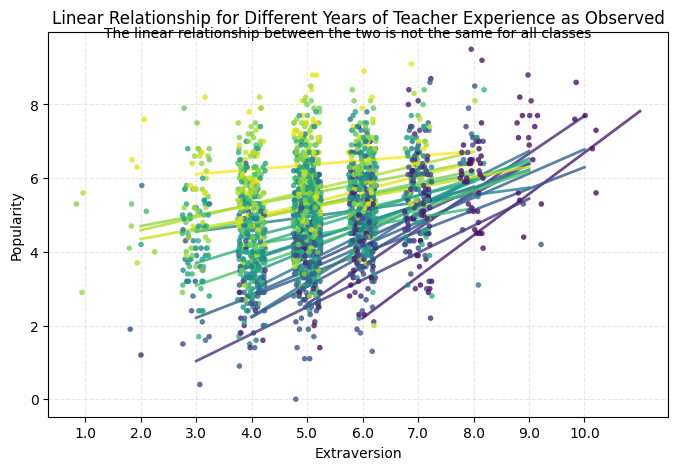

In [55]:
# Ensure texp is treated as categorical
popular2data["texp"] = popular2data["texp"].astype("category")

# Create plot
plt.figure(figsize=(8, 5))

# Scatter plot with jitter
sns.stripplot(
    data=popular2data,
    x="extrav",
    y="popular",
    hue="texp",
    dodge=False,
    alpha=0.8,
    size=4,
    jitter=0.25,
    palette=sns.color_palette("viridis", n_colors=popular2data["texp"].nunique())
)

# Add linear regression line for each texp level
for texp_level in popular2data["texp"].cat.categories:
    subset = popular2data[popular2data["texp"] == texp_level]
    sns.regplot(
        data=subset,
        x="extrav",
        y="popular",
        scatter=False,
        ci=None,
        label=f"Texp {texp_level}",
        color=cm.viridis(int(texp_level) / popular2data["texp"].astype(int).max()),
        line_kws={'alpha': 0.8, 'linewidth': 2}
    )

# Style
plt.title("Linear Relationship for Different Years of Teacher Experience as Observed")
plt.suptitle("The linear relationship between the two is not the same for all classes", fontsize=10, y=0.89)
plt.xlabel("Extraversion")
plt.ylabel("Popularity")
plt.legend(title="Years of\nTeacher\nExperience", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend().remove()
plt.show()

If you want to plot this in a Bayesian way, you could run a simple model and show the different posteriors of the regression slope of extraversion in the 100 different classes.

In [86]:
simplemodel1 = bmb.Model("popular ~ 1 + extrav + (1 + extrav | class)", data=popular2data,
                         center_predictors=False)
fit_simplemodel1 = simplemodel1.fit(draws=4000, tune=1000, chains=2, target_accept=0.96, random_seed=SEED)

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: >], dtype=object)

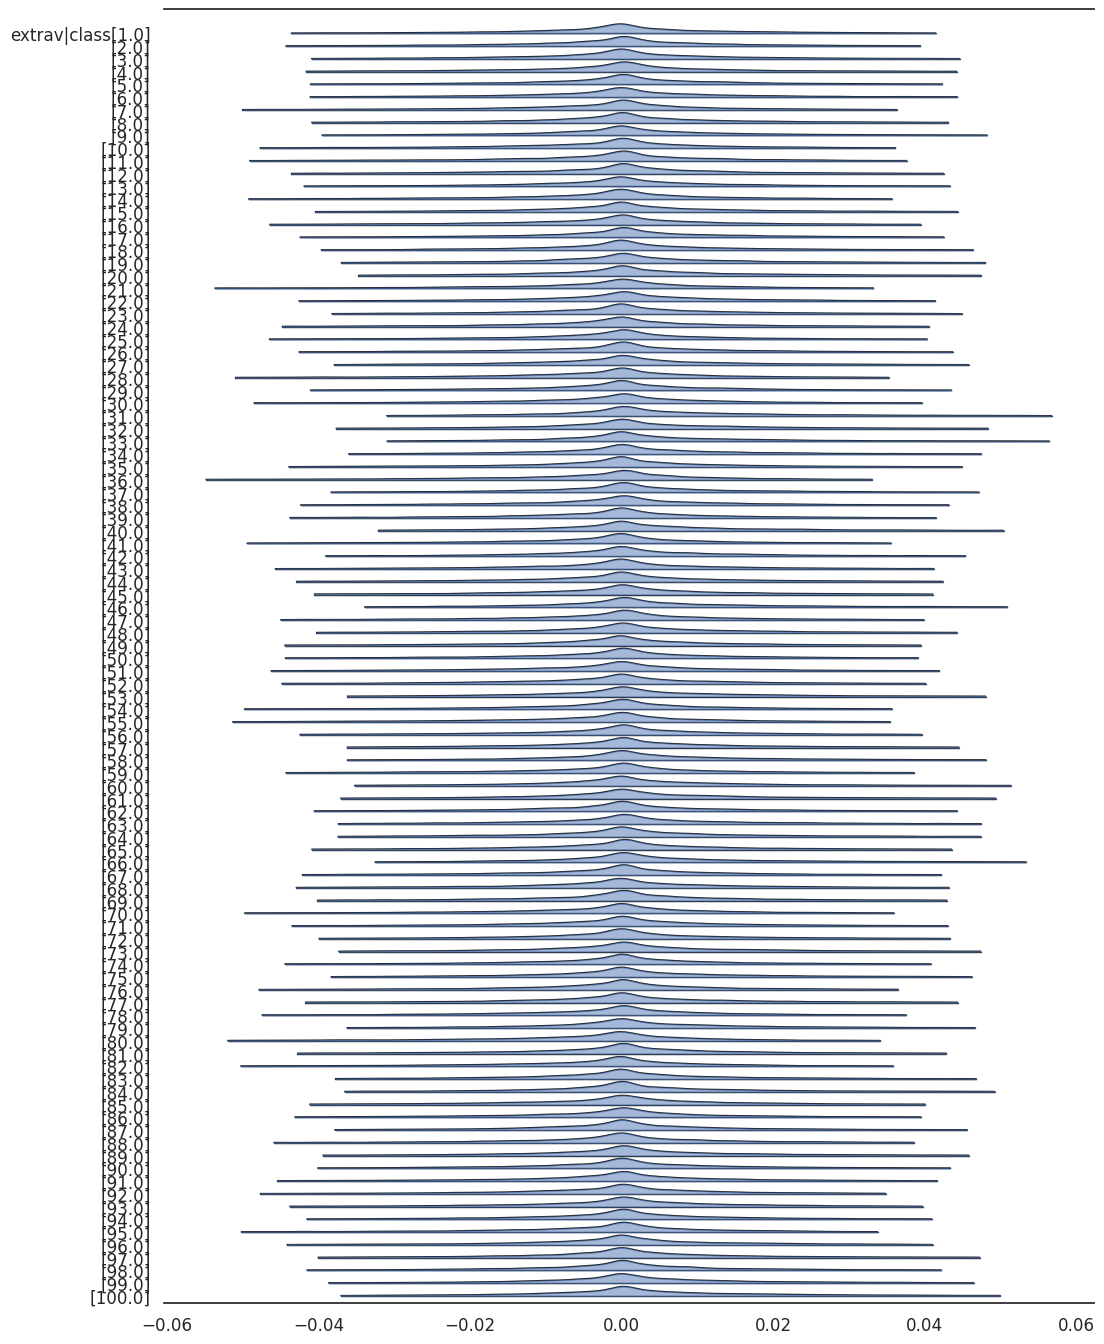

In [87]:
az.plot_forest(fit_simplemodel1, kind="ridgeplot", var_names=["extrav|class"],linewidth=1,
    combined=True, ridgeplot_alpha=0.5)

A plot like this would not be possible in a frequentist analysis. From the width of the different posterior distributions we can see that for the classes with a teacher with less experience we are less sure about the deviation. This means that we are less sure about the estimate of the deviation from the mean for teachers with relatively little experience and are more sure about the random coefficient for classes with a more experienced teacher. We can investigate whether such relation (linear and/or quadratic) actually exists by plotting the distance between the 0.025 and 0.975 CCI for different levels of teaching experience. If we do so, we see that there indeed is a quadratic (and linear) effect and we also see (again) that classes with a teacher with more experience have a positive estimate of the second level error term.